In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import cv2
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam;
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# print(sub_class)
# class_names_labels = {"Normal":0, "Abnormal":1}

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [ ]:
def preprocess(image):
    thresh = cv2.adaptiveThreshold(image.astype(np.uint8),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,21,3)
    thresh = thresh.astype(np.float32)
    thresh = thresh[..., np.newaxis]
    return thresh
# Testing
image = cv2.imread("/kaggle/input/spect-mpi/SPECT_MPI_Dataset/TrainSet/Abnormal/2001.jpg")

In [ ]:
def preprocess_color(image):
    thresh = cv2.adaptiveThreshold(image.astype(np.uint8),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,3)
    thresh = thresh.astype(np.float32)
    thresh = thresh[..., np.newaxis]
    thresh = tf.keras.layers.Concatenate()([thresh, thresh, thresh])
    plt.imshow(thresh)
    return thresh
image = cv2.imread("/kaggle/input/spect-mpi/SPECT_MPI_Dataset/TrainSet/Abnormal/2001.jpg")

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=preprocess,
)

train_datagen_resnet = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
#         preprocessing_function=preprocess_color,
)

train_generator = train_datagen.flow_from_directory(
        '/kaggle/input/spect-mpi/SPECT_MPI_Dataset/TrainSet',
        batch_size=32,
        class_mode='binary',
        color_mode="grayscale",
        target_size=(256,256),
)

train_generator_resnet = train_datagen_resnet.flow_from_directory(
        '/kaggle/input/spect-mpi/SPECT_MPI_Dataset/TrainSet',
        batch_size=32,
        class_mode='binary',
#         color_mode="grayscale",
        target_size=(256,256),
)

test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
        '/kaggle/input/spect-mpi/SPECT_MPI_Dataset/ValidationSet',
        batch_size=32,
        class_mode='binary',
        color_mode="grayscale",
        target_size=(256,256),
)

Found 128 images belonging to 2 classes.
Found 128 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


Sample Image Shape: (32, 256, 256, 3)
Sample Image Data Type: float32


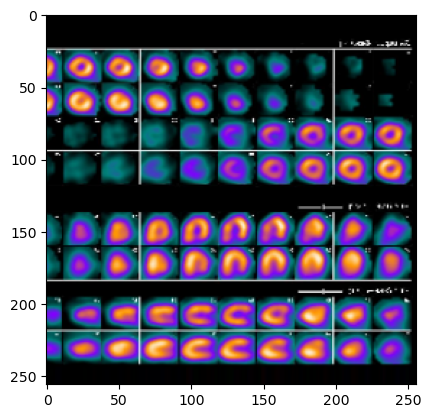

In [ ]:
sample_image, _ = next(train_generator_resnet)
plt.imshow(sample_image[0],cmap="gray")
print("Sample Image Shape:", sample_image.shape)
print("Sample Image Data Type:", sample_image.dtype)

In [ ]:
# model1 = Sequential([
#     Conv2D(filters=64, kernel_size = (11,11), strides = 4, padding="same",activation="relu" ,name="conv_1"),
#     MaxPooling2D(pool_size=(3,3),strides =2, name="pooling_1"),
#     Conv2D(filters=128, kernel_size = (7,7), strides = 1, padding="same",activation="relu" ,name="conv_2"),
#     MaxPooling2D(pool_size=(3,3),strides=2, name="pooling_2"),
#     Conv2D(filters=128, kernel_size = (5,5), strides = 1, padding="same",activation="relu" ,name="conv_3"),
#     Conv2D(filters=256, kernel_size = (3,3), strides = 1, padding="same",activation="relu" ,name="conv_4"),
#     MaxPooling2D(pool_size=(3,3),strides=2, name="pooling_3"),
#     Flatten(),
#     Dense(units = 1024, activation='relu'),
# #     Dropout(0.5),
#     Dense(units = 1024, activation='relu'),
# #     Dropout(0.5),
#     Dense(units = 1, activation='sigmoid')
# ])

# model1.compile(loss=SparseCategoricalCrossentropy(), optimizer = Adam(1e-3), metrics=['accuracy'])
# result = model1.fit(
#         train_generator,
#         epochs=20,
#         validation_data=validation_generator)


model = Sequential([
    Conv2D(64, (11, 11), strides=4, padding='valid', activation='relu',input_shape=(256,256,1)),
    MaxPooling2D((3, 3), strides=2),
    BatchNormalization(),
    Conv2D(128, (7, 7), strides=1, padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=2),
    BatchNormalization(),
    Conv2D(128, (5, 5), strides=1, padding='valid', activation='relu'),
    Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=2),
    BatchNormalization(),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='sigmoid')
])

# Compile the model with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=(9e-4))
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
history = model.fit(
    train_generator,
    epochs=50,
    verbose=1,
    validation_data=validation_generator)

Epoch 1/50
4/4 [==============================] - 6s 460ms/step - loss: 1.8545 - accuracy: 0.6250 - val_loss: 1.0141 - val_accuracy: 0.7812
Epoch 2/50
4/4 [==============================] - 2s 432ms/step - loss: 0.9771 - accuracy: 0.7344 - val_loss: 0.9163 - val_accuracy: 0.7812
Epoch 3/50
4/4 [==============================] - 2s 432ms/step - loss: 0.8730 - accuracy: 0.6875 - val_loss: 0.7663 - val_accuracy: 0.7812
Epoch 4/50
4/4 [==============================] - 2s 469ms/step - loss: 1.0375 - accuracy: 0.7188 - val_loss: 0.6265 - val_accuracy: 0.7812
Epoch 5/50
4/4 [==============================] - 2s 434ms/step - loss: 1.2004 - accuracy: 0.7188 - val_loss: 0.5878 - val_accuracy: 0.7812
Epoch 6/50
4/4 [==============================] - 2s 459ms/step - loss: 0.9804 - accuracy: 0.6172 - val_loss: 0.5757 - val_accuracy: 0.7812
Epoch 7/50
4/4 [==============================] - 2s 432ms/step - loss: 0.9191 - accuracy: 0.7500 - val_loss: 0.5886 - val_accuracy: 0.7812
Epoch 8/50
4/4 [====

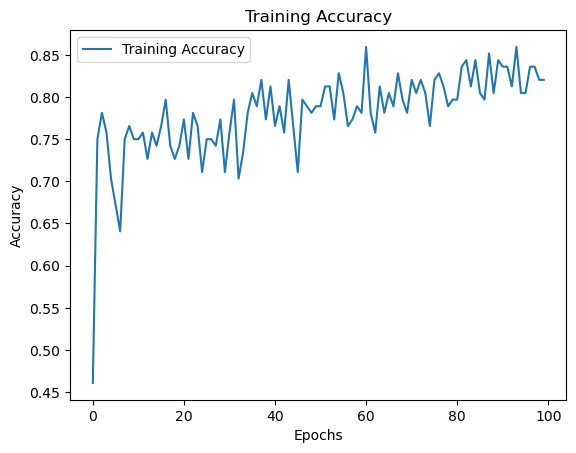

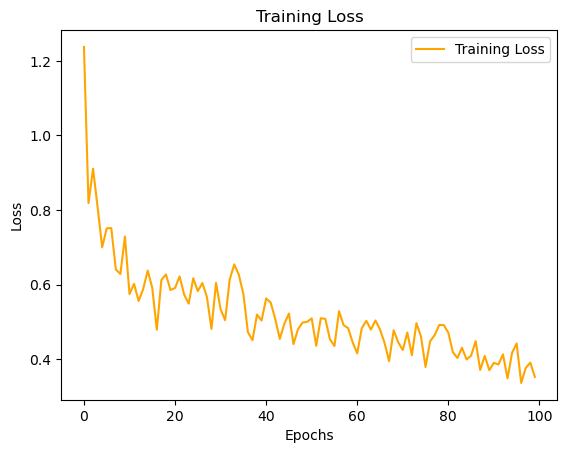

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [ ]:
model2 = Sequential([
    Conv2D(filters=64, kernel_size=(11,11), strides=(4,4), activation='relu', padding="valid",input_shape=(227,227,1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="valid"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="valid"),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="valid"),
    BatchNormalization(),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model2.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
model2.summary()

NameError: name 'Sequential' is not defined

In [ ]:
history = model2.fit(train_generator,epochs=100,verbose=1, validation_data=validation_generator)

Epoch 1/100
4/4 [==============================] - 7s 439ms/step - loss: 1.1467 - accuracy: 0.5625 - val_loss: 1.0623 - val_accuracy: 0.7812
Epoch 2/100
4/4 [==============================] - 1s 381ms/step - loss: 0.9371 - accuracy: 0.7344 - val_loss: 1.0057 - val_accuracy: 0.7812
Epoch 3/100
4/4 [==============================] - 2s 394ms/step - loss: 0.7719 - accuracy: 0.7500 - val_loss: 0.9466 - val_accuracy: 0.7812
Epoch 4/100
4/4 [==============================] - 2s 397ms/step - loss: 0.7420 - accuracy: 0.7031 - val_loss: 0.8874 - val_accuracy: 0.7812
Epoch 5/100
4/4 [==============================] - 2s 383ms/step - loss: 0.7687 - accuracy: 0.6641 - val_loss: 0.8259 - val_accuracy: 0.7812
Epoch 6/100
4/4 [==============================] - 2s 420ms/step - loss: 0.8901 - accuracy: 0.6953 - val_loss: 0.7770 - val_accuracy: 0.7812
Epoch 7/100
4/4 [==============================] - 2s 393ms/step - loss: 0.8637 - accuracy: 0.7109 - val_loss: 0.7445 - val_accuracy: 0.7812
Epoch 8/100
4

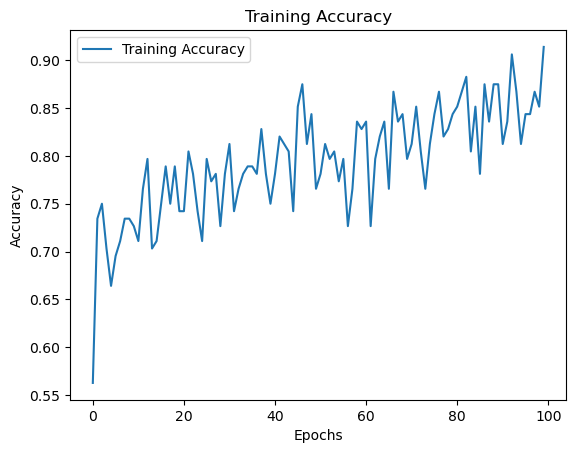

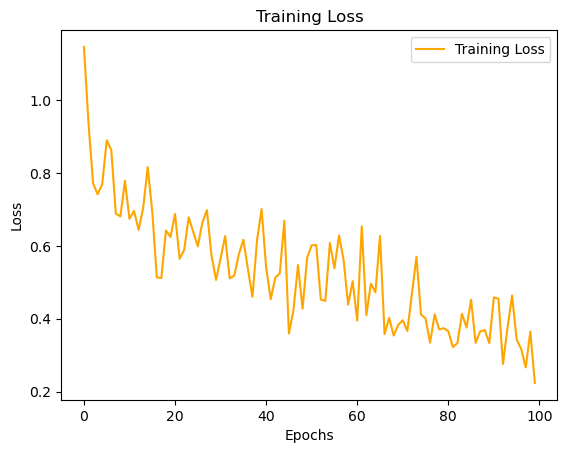

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [ ]:
model3 = Sequential()

resnet50 = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(256,256,3),
    pooling='max',
    classes=2
)

for layer in resnet50.layers:
    layer.trainable=True

model3.add(resnet50)
model3.add(Flatten())
model3.add(Dense(512,activation='relu'))
model3.add(Dense(1,activation="sigmoid"))

In [ ]:
 model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dense_9 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,637,313
Trainable params: 24,584,193
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=(1e-4))
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model3.fit(
    train_generator_resnet,
    epochs=10,
    verbose=1,
)

Epoch 1/10
4/4 [==============================] - 43s 494ms/step - loss: 3.0379 - accuracy: 0.5859
Epoch 2/10
4/4 [==============================] - 3s 624ms/step - loss: 2.7538 - accuracy: 0.7891
Epoch 3/10
4/4 [==============================] - 3s 641ms/step - loss: 0.7591 - accuracy: 0.7891
Epoch 4/10
4/4 [==============================] - 3s 665ms/step - loss: 0.8728 - accuracy: 0.7969
Epoch 5/10
4/4 [==============================] - 3s 617ms/step - loss: 0.8328 - accuracy: 0.8438
Epoch 6/10
4/4 [==============================] - 3s 653ms/step - loss: 0.8295 - accuracy: 0.7891
Epoch 7/10
4/4 [==============================] - 3s 623ms/step - loss: 0.6383 - accuracy: 0.8672
Epoch 8/10
4/4 [==============================] - 3s 647ms/step - loss: 0.6696 - accuracy: 0.8438
Epoch 9/10
4/4 [==============================] - 3s 628ms/step - loss: 0.3046 - accuracy: 0.8984
Epoch 10/10
4/4 [==============================] - 3s 643ms/step - loss: 0.3144 - accuracy: 0.8984


In [ ]:
model4 = Sequential([
    Conv2D(64, (11, 11), strides=4, padding='same', activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((3, 3), strides=2),
    BatchNormalization(),
    Flatten(),
    Reshape(3, 10, 2),
    LSTM(units=64, return_sequences=True),
#     Reshape((31, 31, 64)),
    Conv2D(128, (7, 7), strides=1, padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=2),
    BatchNormalization(),
    Conv2D(128, (5, 5), strides=1, padding='valid', activation='relu'),
    Conv2D(256, (3, 3), strides=1, padding='valid', activation='relu'),
    Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=2),
    BatchNormalization(),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=(1e-4))
model4.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

TypeError: Reshape.__init__() takes 2 positional arguments but 4 were given

In [ ]:
history = model4.fit(
    train_generator,
    epochs=10,
    verbose=1,
)

NameError: name 'model4' is not defined